In [18]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import sklearn.datasets as ds

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split

# Projecting high-dimensional data to low-dimensional space 

In many cases, the data we are going to work with are going to be high dimensional. Since humans are visually inclined, we would like to look at the data to make some deductions. But since we cannot visualize a high number of dimensions, we must find ways to project point clouds in high dimensional spaces into spaces of lower dimension. For this purpose, today we are going to look at 3 methods.

## All possible projections

The simplest way of visualizing a high dimensional dataset is projecting onto any 2 selected dimension. I'll show some examples of this approach below. However, this approach is blind to the labels we might have for the data points. In most cases, we want to project the data in such a way that we separate different labeled points from each other as best as we can, while we keep points sharing the same label as close as we can.

## Principal Component Analysis (PCA)

PCA is another method that is blind to any possible labels the points we have in our dataset. However, instead of simply projecting data randomly on any two selected axes, PCA finds a projection in such a way that it preserves the variation in the data.

(Image source: [Wikipedia](https://en.wikipedia.org/wiki/Principal_component_analysis))
![Gaussian Scatter PCA](./images/GaussianScatterPCA.png)

Assume we have a collection of data points $x^{(i)}\in \mathbb{R}^n$ where $i=1,2,\ldots,N$ for some $n$ and $N$.  We consider the data points as a matrix $X$ of row size $N$ and column size $n$.  We look at the covariance matrix $X^tX$. The matrix is a symmetric real valued matrix and as such has real eigen values. Moreover, the eigenvectors are mutually orthogonal. This means, the covariance matrix gives us $n$ orthogonal vectors (directions) in $\mathbb{R}^n$ where our data points are embedded. Moreover, the size of the eigen value tells us the distribution of the data points along the corresponding eigenvector. Thus the larger the eigen value, the larger the distribution.

## Linear Discriminant Analysis (LDA)

The approaches I outlined above are blind to the class labels the data points might have. If we have class labels then we would like to keep points having the same labels together while we separate points of different labels as separate as possible. There is a linear algebraic method to do this. The method is called [Linear Discriminant Analysis (LDA)](https://en.wikipedia.org/wiki/Linear_discriminant_analysis).

Here, I am going to outline LDA with 2 class labels. Assume we have data points embedded in a high dimensional space with two labels: 0 and 1. Let $C_0$ and $C_1$ be the set of points (that viewed as a matrix) has the labels 0 and 1 respectively.

Then if we consider the class means
$$ \mu_i = \frac{1}{|C_i|}\sum_{x\in C_i} x $$
and class covariances
$$ \Sigma_i = \sum_{x\in C_i} (x-\mu_i)^t(x-\mu_i) $$
Now, let $P\colon \mathbb{R}^n\to \mathbb{R}^m$ be a projection matrix. Then we have
$$ S_P = \frac{\sigma^2_\text{between}(P)}{\sigma^2_\text{within}(P)} = \frac{\|P(\mu_0-\mu_1)\|}{\|P(\Sigma_0+\Sigma_1)\|} $$
In other words, we must find a $P$ that maximizes $S_P$.

## t-Distributed Stochastic Neighbor Embedding (TSNE)

[t-distributed stochastic neighbor embedding (TSNE)](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) is a relatively new method projecting data into a lower dimensional space $x^{(i)}\mapsto y^{(i)}$ using [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence).

First we calculate
$$ p_{j|i} = \frac{e^{-\|x^{(i)}-x^{(j)}\|}}{\sum_{i\neq k} e^{-\|x^{(i)}-x^{(k)}\|}} $$
and let
$$ p_{ij} = \frac{p_{j|i}+p_{i|j}}{N} $$
We want a mapping $x^{(i)}\mapsto y^{(i)}$ such that the probability distribution $p_{ij}$ and the $q_{ij}$
$$ q_{ij} = \frac{(1+\|y^{(i)}-y^{(j)}\|^2)^{-1}}{\sum_k \sum_{\ell\neq k} (1+\|y^{(k)}-y^{(\ell)}\|^2)^{-1}} $$
have minimal KL-divergence
$$ KL(P|Q) = \sum_{i\neq j} p_{ij} \log (p_{ij}/q_{ij}) $$

# Examples

## Iris Dataset

In [37]:
iris = ds.load_iris()
xs = iris['data']
ys = iris['target']

In [38]:
print(xs.shape)
print(np.unique(ys))

(150, 4)
[0 1 2]


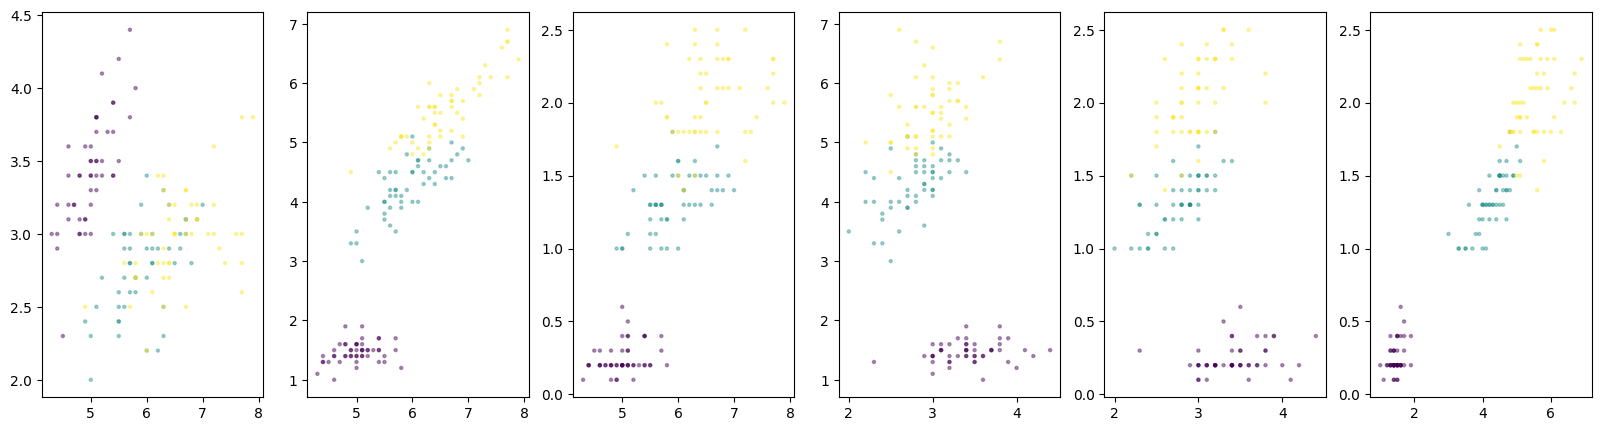

In [180]:
pairs = [(0,1),(0,2),(0,3),(1,2),(1,3),(2,3)]
fig, ax = plt.subplots(ncols=6, figsize=(20,5))

for i,(j,k) in enumerate(pairs):
    ax[i].scatter(xs[:,j],xs[:,k],c=ys,s=5,alpha=0.4)

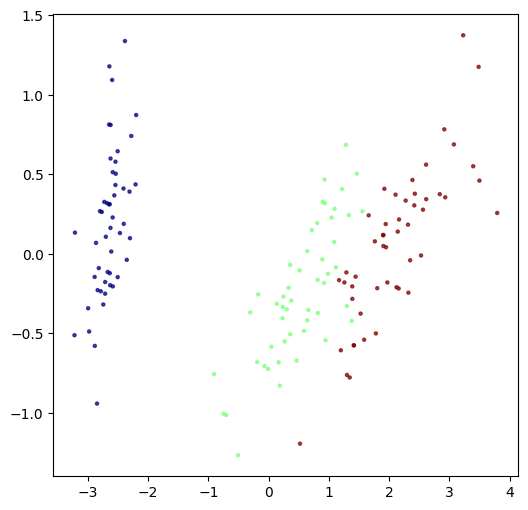

In [39]:
projector = PCA(n_components=2)
points = projector.fit_transform(xs)
plt.figure(figsize=(6,6))
plt.scatter(points[:,0],points[:,1],s=5,alpha=0.7,c=ys,cmap='jet')

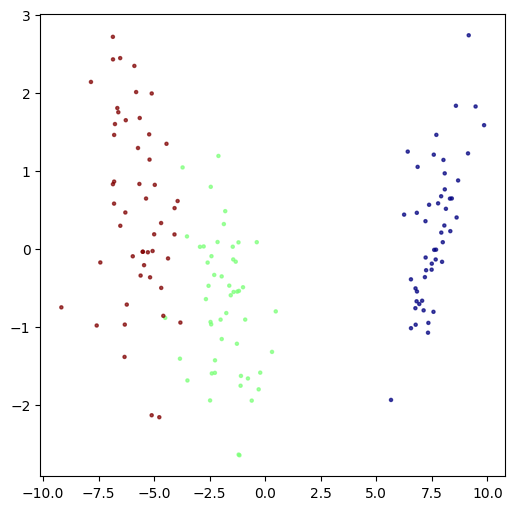

In [40]:
projector = LDA(n_components=2)
points = projector.fit_transform(xs,ys)
plt.figure(figsize=(6,6))
plt.scatter(points[:,0],points[:,1],s=5,alpha=0.7,c=ys,cmap='jet')

/home/kaygun/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/kaygun/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


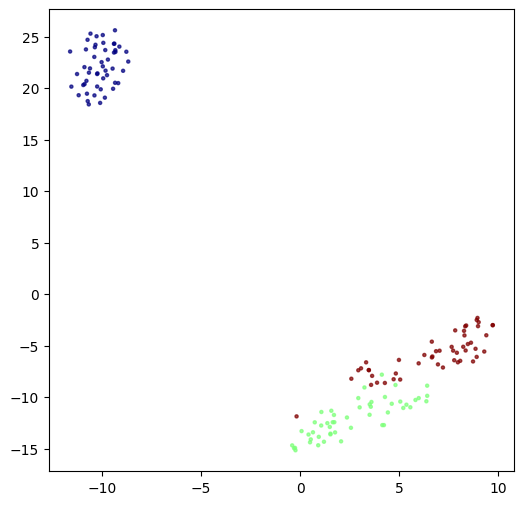

In [41]:
projector = TSNE(n_components=2)
points = projector.fit_transform(xs,ys)
plt.figure(figsize=(6,6))
plt.scatter(points[:,0],points[:,1],s=5,alpha=0.7,c=ys,cmap='jet')

## Wine Dataset

In [42]:
raw = ds.load_wine()
xs = raw['data']
ys = raw['target']
print(xs.shape)
print(np.unique(ys))

(178, 13)
[0 1 2]


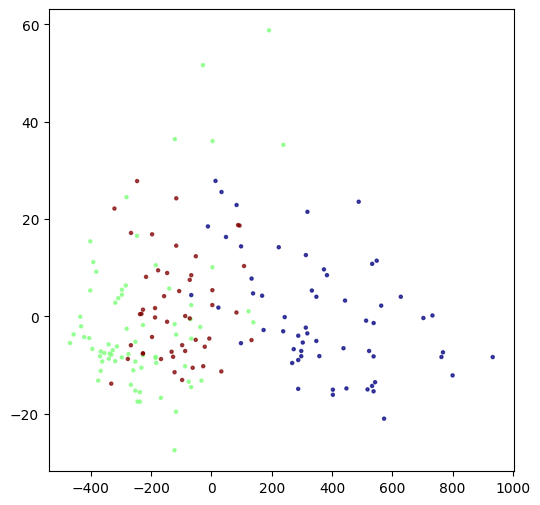

In [43]:
projector = PCA(n_components=2)
points = projector.fit_transform(xs)
plt.figure(figsize=(6,6))
plt.scatter(points[:,0],points[:,1],s=5,alpha=0.7,c=ys,cmap='jet')

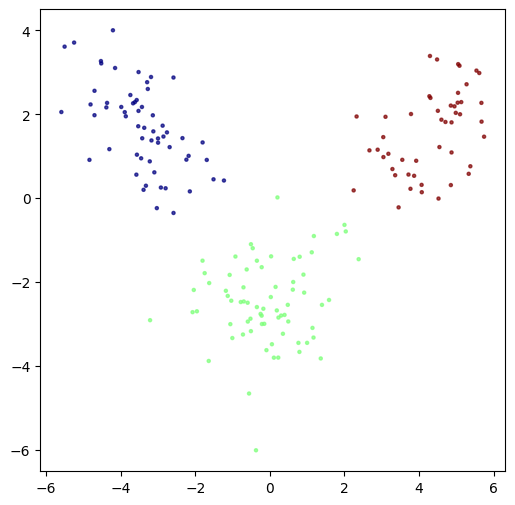

In [44]:
projector = LDA(n_components=2)
points = projector.fit_transform(xs,ys)
plt.figure(figsize=(6,6))
plt.scatter(points[:,0],points[:,1],s=5,alpha=0.7,c=ys,cmap='jet')

/home/kaygun/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/kaygun/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


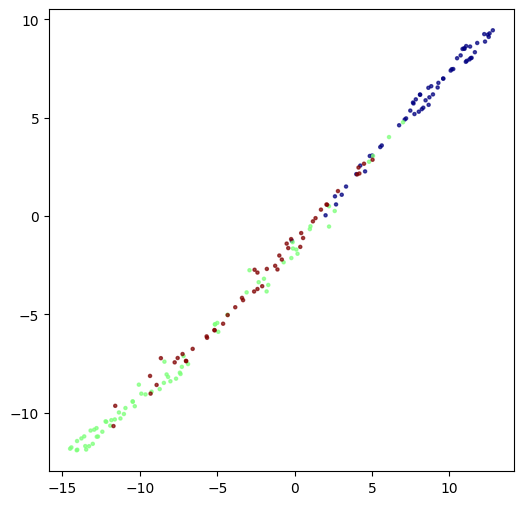

In [45]:
projector = TSNE(n_components=2)
points = projector.fit_transform(xs)
plt.figure(figsize=(6,6))
plt.scatter(points[:,0],points[:,1],s=5,alpha=0.7,c=ys,cmap='jet')

## FMNIST

In [21]:
def tfGetData(df,N,attr=None):
    X = []
    y = []
    fn = {True: 1, False: 0}
    for u in df.take(N):
        X.append(u['image'].numpy())
        if attr == None:
            y.append(u['label'].numpy())
        else:
            y.append(fn.get(u['attributes'][attr].numpy(),0))
    return np.array(X),np.array(y)

2022-11-18 15:48:40.763330: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


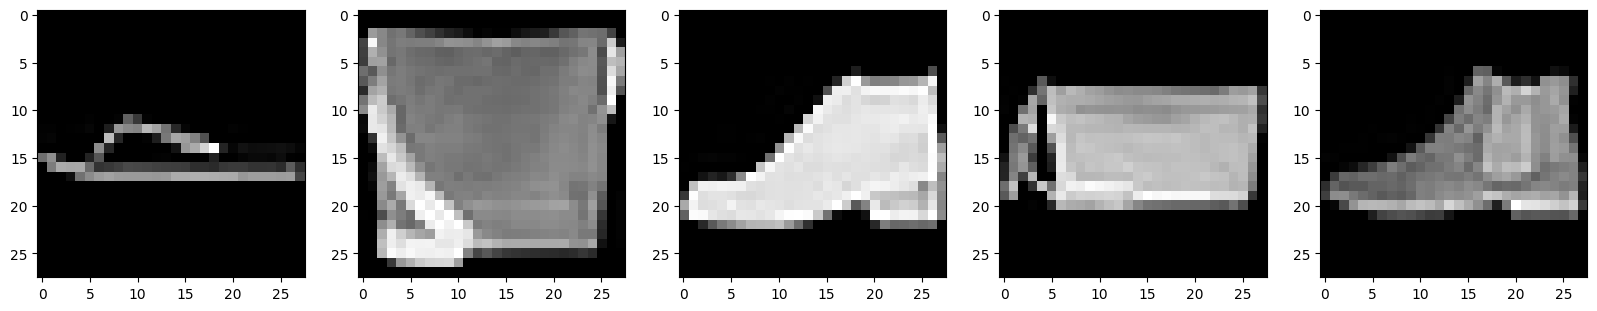

In [46]:
fmnist_data,fmnist_info = tfds.load("fashion_mnist", split="train",
                                     with_info=True,
                                     data_dir='/home/kaygun/local/data/tensorflow_datasets/')
N = 600
m = 5
xs,ys = tfGetData(fmnist_data,N)
fig, ax = plt.subplots(ncols=m, figsize=(20,8))
for i in range(m):
    j = np.random.randint(N)
    ax[i].imshow(xs[j],cmap='gray')

In [47]:
print(xs.shape)
print(np.unique(ys))

(600, 28, 28, 1)
[0 1 2 3 4 5 6 7 8 9]


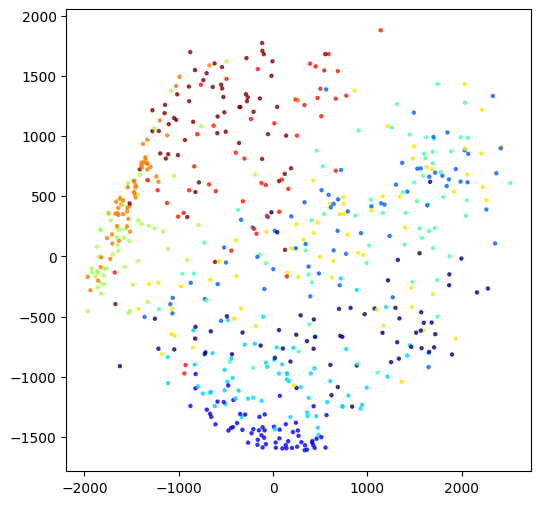

In [48]:
projector = PCA(n_components=2)
points = projector.fit_transform(xs.reshape(600,28*28))
plt.figure(figsize=(6,6))
plt.scatter(points[:,0],points[:,1],s=5,alpha=0.7,c=ys,cmap='jet')

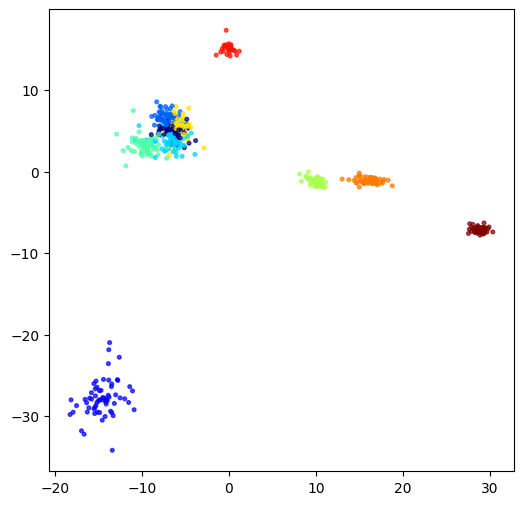

In [49]:
projector = LDA(n_components=2)
points = projector.fit_transform(xs.reshape(600,28*28),ys)
plt.figure(figsize=(6,6))
plt.scatter(points[:,0],points[:,1],s=7,alpha=0.7,c=ys,cmap='jet')

In [ ]:
projector = TSNE(n_components=2)
points = projector.fit_transform(xs.reshape(600,28*28),ys)
plt.figure(figsize=(6,6))
plt.scatter(points[:,0],points[:,1],s=7,alpha=0.7,c=ys,cmap='jet')

/home/kaygun/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/kaygun/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


## CELEB_A

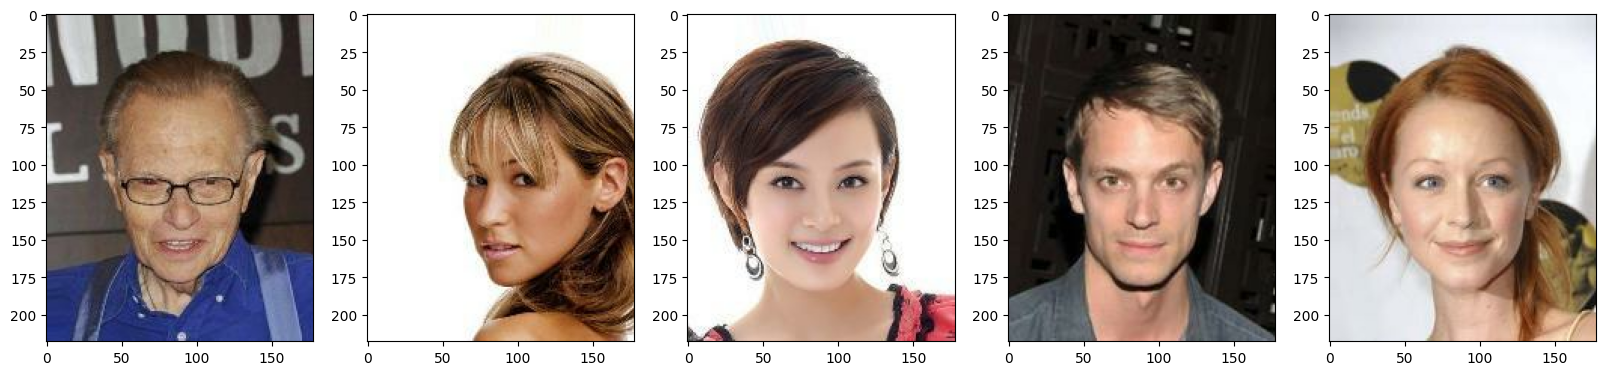

In [29]:
celeba_data,celeba_info = tfds.load("celeb_a", split="train",
                                  with_info=True,
                                  data_dir='/home/kaygun/local/data/tensorflow_datasets/')
N = 600
m = 5
xs,ys = tfGetData(celeba_data,N,'Male')
fig, ax = plt.subplots(ncols=m, figsize=(20,8))
for i in range(m):
    j = np.random.randint(N)
    ax[i].imshow(xs[j],cmap='gray')

In [30]:
xs.shape

(600, 218, 178, 3)

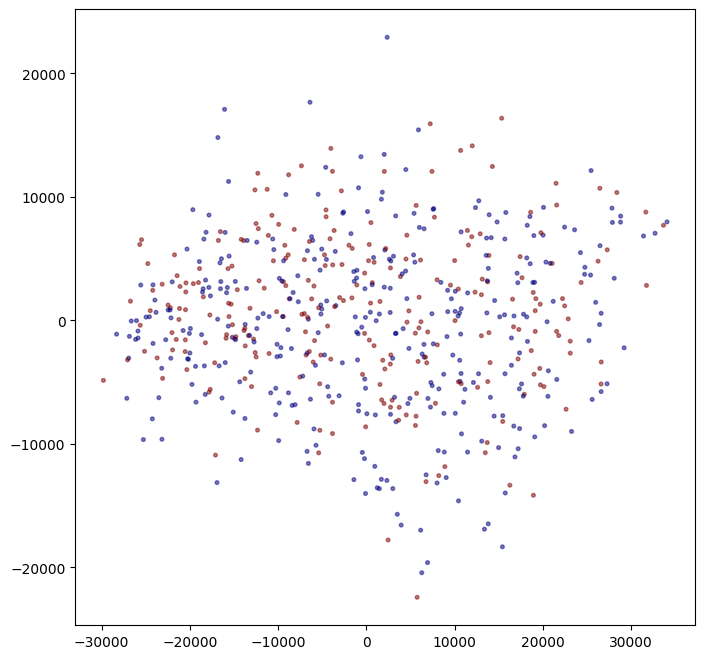

In [31]:
projector = PCA(n_components=2)
points = projector.fit_transform(xs.reshape((600,218*178*3)))
plt.figure(figsize=(8,8))
plt.scatter(points[:,0],points[:,1],s=7,alpha=0.5,c=ys,cmap='jet')

/home/kaygun/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/kaygun/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


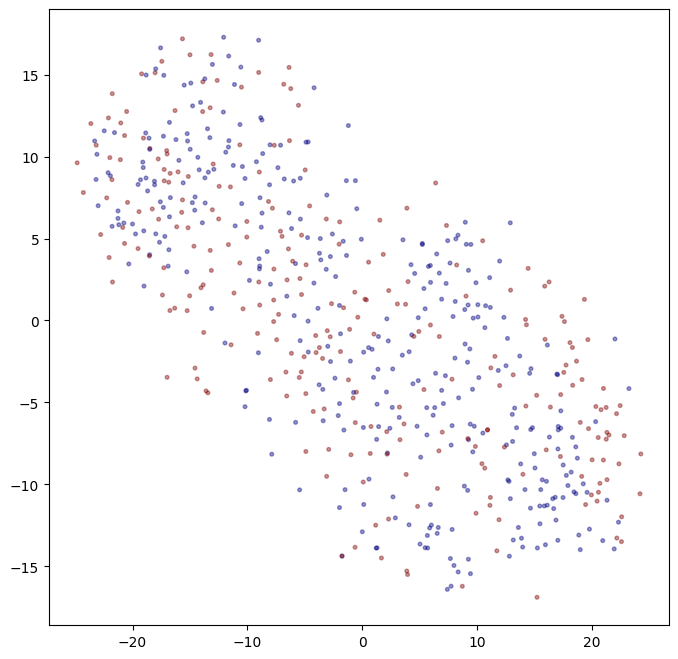

In [32]:
projector = TSNE(n_components=2)
points = projector.fit_transform(xs.reshape((600,218*178*3)),ys)
plt.figure(figsize=(8,8))
plt.scatter(points[:,0],points[:,1],s=7,alpha=0.4,c=ys,cmap='jet')

## MNIST

2022-11-18 15:46:54.665720: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


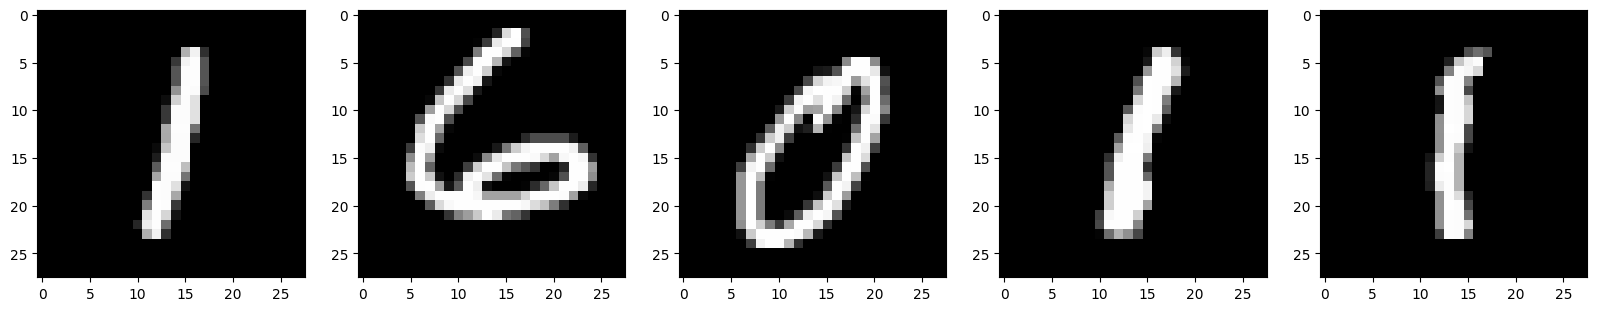

In [33]:
mnist_data,mnist_info = tfds.load("mnist", split="train",
                                  with_info=True,
                                  data_dir='/home/kaygun/local/data/tensorflow_datasets/')
N = 600
m = 5
xs,ys = tfGetData(mnist_data,N)
fig, ax = plt.subplots(ncols=m, figsize=(20,8))
for i in range(m):
    j = np.random.randint(N)
    ax[i].imshow(xs[j],cmap='gray')

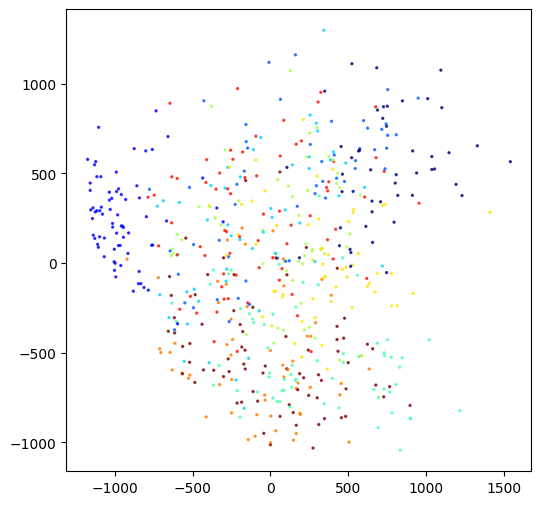

In [34]:
projector = PCA(n_components=2)
points = projector.fit_transform(xs.reshape((600,28*28)),ys)
plt.figure(figsize=(6,6))
plt.scatter(points[:,0],points[:,1],s=2,alpha=0.7,c=ys,cmap='jet')

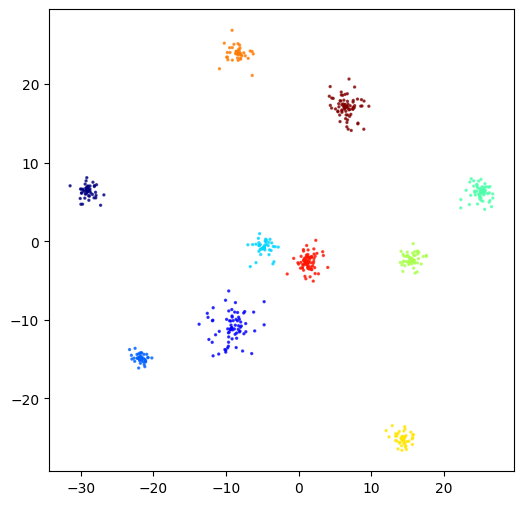

In [35]:
projector = LDA(n_components=2)
points = projector.fit_transform(xs.reshape((600,28*28)),ys)
plt.figure(figsize=(6,6))
plt.scatter(points[:,0],points[:,1],s=2,alpha=0.7,c=ys,cmap='jet')

/home/kaygun/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/kaygun/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


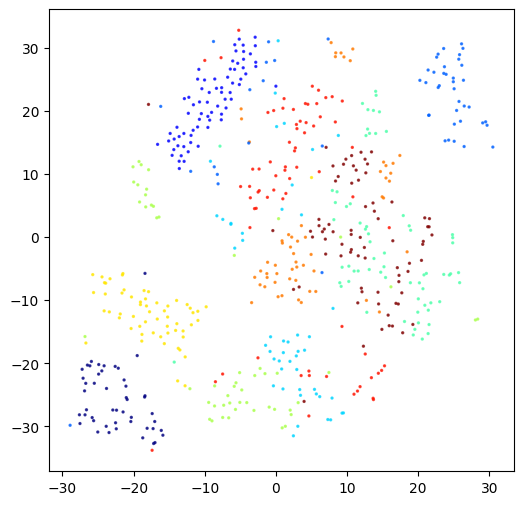

In [36]:
projector = TSNE(n_components=2)
points = projector.fit_transform(xs.reshape((600,28*28)),ys)
plt.figure(figsize=(6,6))
plt.scatter(points[:,0],points[:,1],s=2,alpha=0.7,c=ys,cmap='jet')

## Olivetti Faces Dataset

In [207]:
olivetti = ds.fetch_olivetti_faces()
xs = olivetti['data']
ys = olivetti['target']

In [208]:
print(xs.shape)
print(np.unique(ys))

(400, 4096)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


In [209]:
np.sqrt(4096)

64.0

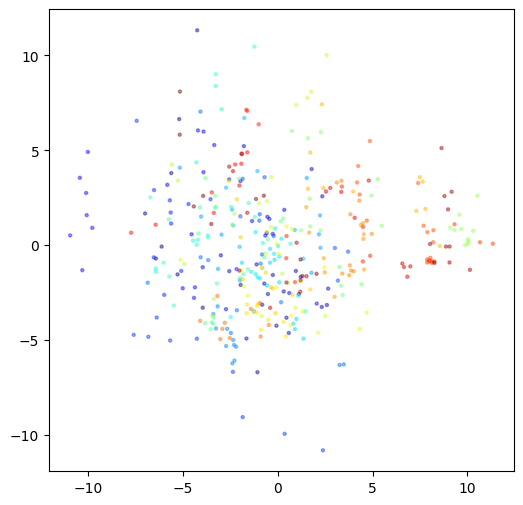

In [210]:
projector = PCA(n_components=2)
points = projector.fit_transform(xs)
plt.figure(figsize=(6,6))
plt.scatter(points[:,0],points[:,1],c=ys,s=5,alpha=0.4,cmap='jet')

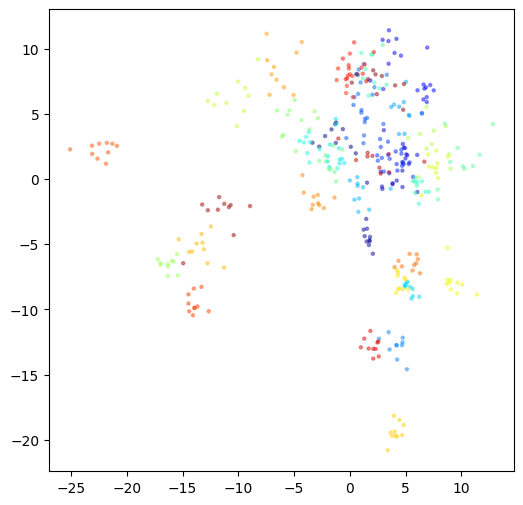

In [212]:
projector = LDA(n_components=2)
points = projector.fit_transform(xs,ys)
plt.figure(figsize=(6,6))
plt.scatter(points[:,0],points[:,1],c=ys,s=5,alpha=0.4,cmap='jet')

/home/kaygun/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/kaygun/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


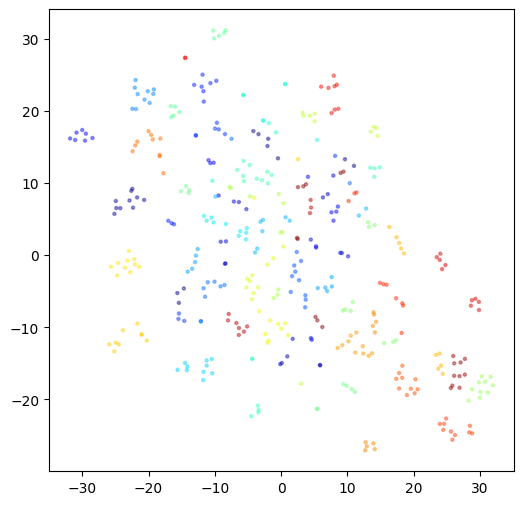

In [213]:
projector = TSNE(n_components=2)
points = projector.fit_transform(xs,ys)
plt.figure(figsize=(6,6))
plt.scatter(points[:,0],points[:,1],c=ys,s=5,alpha=0.4,cmap='jet')

## Newsgroup

In [2]:
news = ds.fetch_20newsgroups()

In [3]:
news['data'][0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

In [4]:
print(np.unique(news['target']))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [5]:
vectorizer = CountVectorizer()
xs = vectorizer.fit_transform(news['data']).toarray()
ys = news['target']

In [6]:
print(xs.shape)

(11314, 130107)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(xs,ys,train_size=0.1,test_size=0.1)

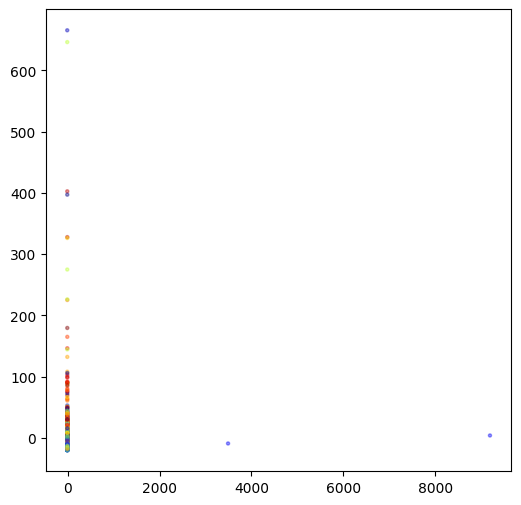

In [9]:
projector = PCA(n_components=2)
points = projector.fit_transform(X_train)
plt.figure(figsize=(6,6))
plt.scatter(points[:,0],points[:,1],c=y_train,s=5,alpha=0.4,cmap='jet')

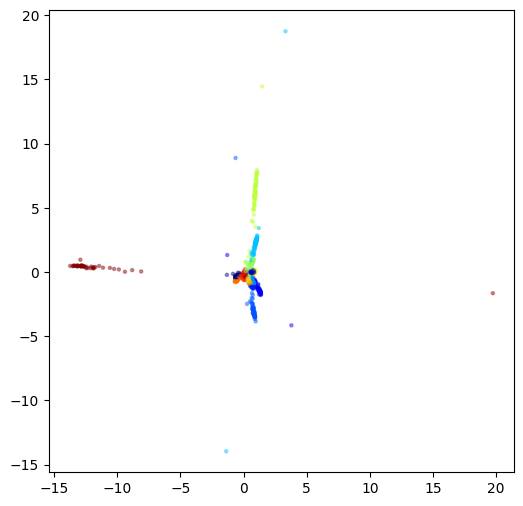

In [10]:
projector = LDA(n_components=2)
points = projector.fit_transform(X_train,y_train)
plt.figure(figsize=(6,6))
plt.scatter(points[:,0],points[:,1],c=y_train,s=5,alpha=0.4,cmap='jet')

/home/kaygun/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/kaygun/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


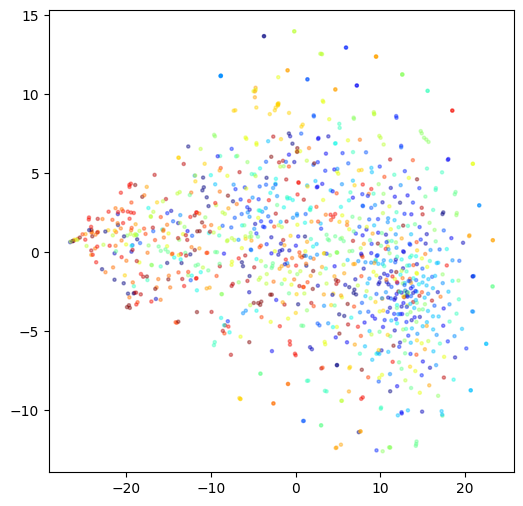

In [11]:
projector = TSNE(n_components=2)
points = projector.fit_transform(X_train,y_train)
plt.figure(figsize=(6,6))
plt.scatter(points[:,0],points[:,1],c=y_train,s=5,alpha=0.4,cmap='jet')

## Covering Type


In [12]:
covering = ds.fetch_covtype()
xs = covering['data']
ys = covering['target']

In [13]:
print(xs.shape)
print(np.unique(ys))

(581012, 54)
[1 2 3 4 5 6 7]


In [14]:
X_train, X_test, y_train, y_test = train_test_split(xs,ys,train_size=0.005,test_size=0.005)

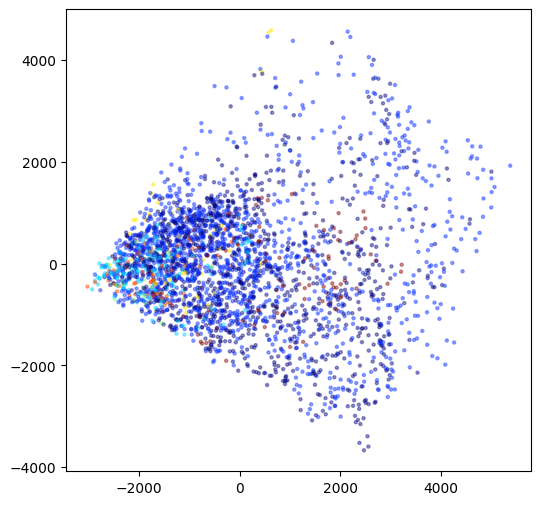

In [15]:
projector = PCA(n_components=2)
points = projector.fit_transform(X_train)
plt.figure(figsize=(6,6))
plt.scatter(points[:,0],points[:,1],c=y_train,s=5,alpha=0.4,cmap='jet')

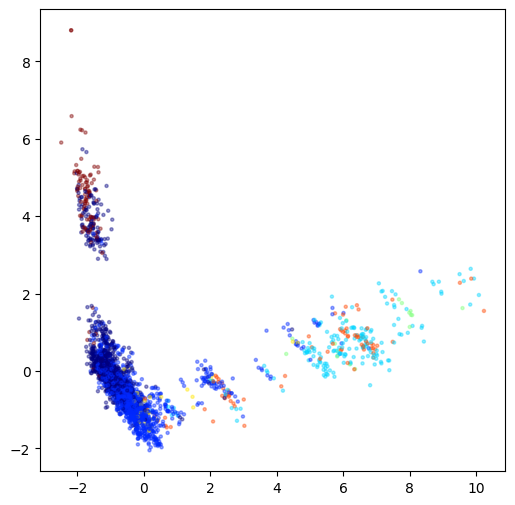

In [16]:
projector = LDA(n_components=2)
points = projector.fit_transform(X_train,y_train)
plt.figure(figsize=(6,6))
plt.scatter(points[:,0],points[:,1],c=y_train,s=5,alpha=0.4,cmap='jet')

/home/kaygun/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/kaygun/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


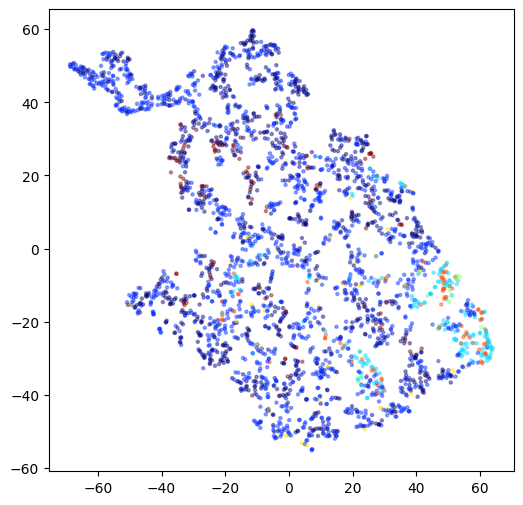

In [17]:
projector = TSNE(n_components=2)
points = projector.fit_transform(X_train,y_train)
plt.figure(figsize=(6,6))
plt.scatter(points[:,0],points[:,1],c=y_train,s=5,alpha=0.4,cmap='jet')